<h1>Heart Disease Predictor</h1><br>

What this does:
This is a basic Machine Learning classification project that predicts if a patient has heart disease or not by analysing 9 medical conditions of the patient. In this project I've walked through various models and applied various algorithms to find the best model with higher prediction accuracy. This absolutely by no means the best we can do with this data but it's the best I can do so far.
<br><br>
Purpose: To predict if a patient has some heart disease or not<br>
Number of features required for prediction: 9<br>
Best prediction accuracy achieved: 90.10% accurate(Used *accuracy_score* metric system)

In [288]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import collections

In [2]:
#Importing data refining modules
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate

#Importing Classifying Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm

#Performance measuring modules
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score

<h2>Refining Data if required<h2>

In [3]:
data = pd.read_csv('heart.csv')
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


**Description of the Dataset**

Age:       Age of the person<br>
Sex:       Gender<br>
CP :       Chest Pain type (4 values)<br>
trestbps:  Resting Blood Pressure<br>
chol :     serum cholestoral in mg/dl<br>
fbs:       fasting blood sugar > 120 mg/dl<br>
restecg:   resting electrocardiographic results (values 0,1,2)<br>
thalach:   maximum heart rate achieved<br>
exang:     exercise induced angina<br>
oldpeak :  ST depression induced by exercise relative to rest<br>
slope:     the slope of the peak exercise ST segment<br>
ca:        number of major vessels (0-3) colored by flourosopy<br>
thal:      3 = normal; 6 = fixed defect; 7 = reversable defect<br>

target: Binary Value ==> 0: No disease, 1: Disease

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


No null values

<h2>Feature Selection<h2>

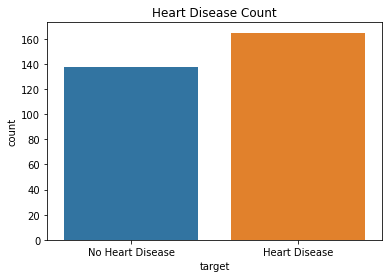

In [6]:
sns.countplot(x='target' ,data=data)
plt.xticks([0,1], ['No Heart Disease', 'Heart Disease'])
plt.title('Heart Disease Count')
plt.show()

Almost balanced data

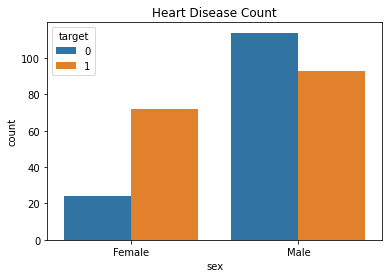

In [7]:
sns.countplot(x='sex', data = data, hue='target')
plt.xticks([0,1], ['Female', 'Male'])
plt.title('Heart Disease Count')
plt.show()

Mens are likely to have heart disease slightly more.

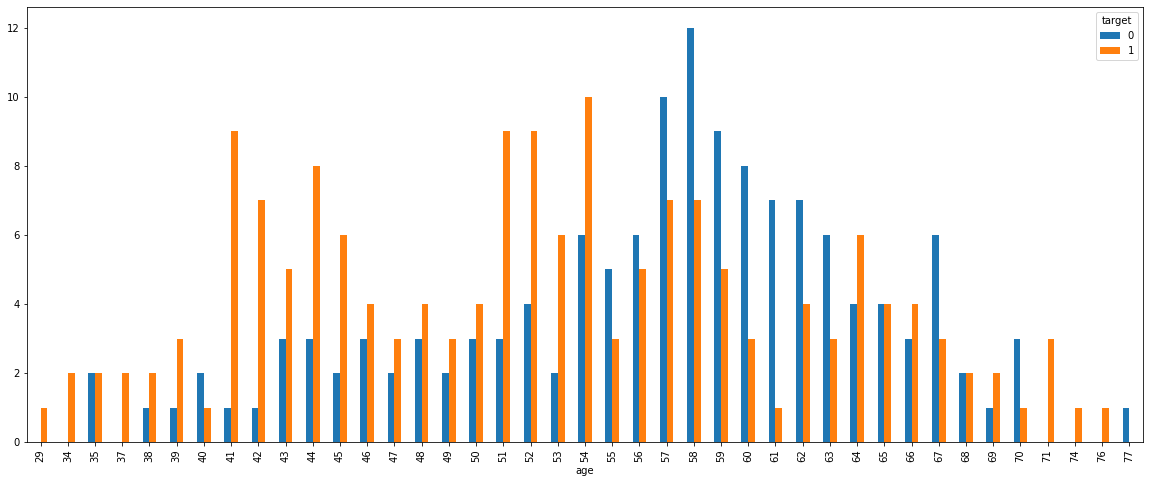

In [8]:
pd.crosstab(data.age, data.target).plot(kind='bar', figsize=(20,8))

There are significantly more people with heart disease from age 37 to 54 than in other age group.


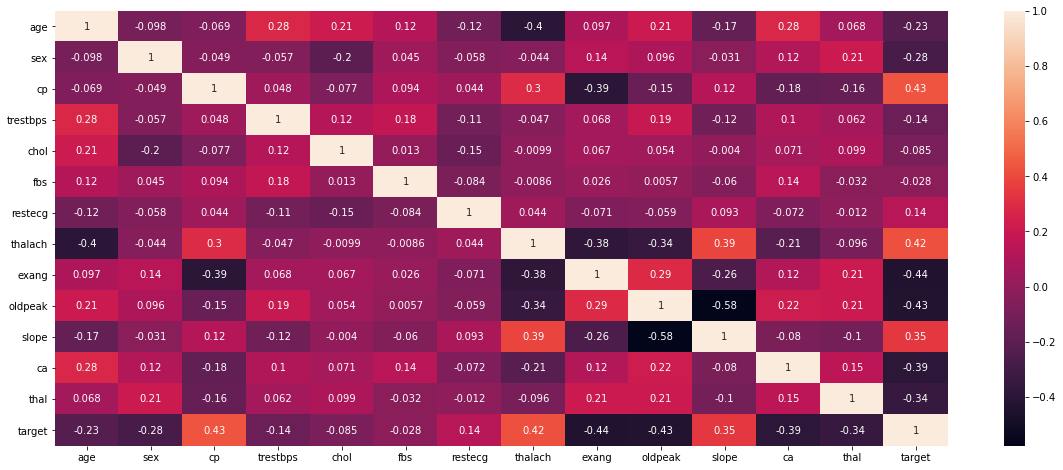

In [9]:
_, axs = plt.subplots(figsize=(20,8))
sns.heatmap(data=data.corr(), annot=True)

**Features with Correlation > 0.3 with target**


1.   Thal
2.   CA
3.   slope
4.   oldpeak
5.   exang
6.   thalach
7.   cp


In [10]:
data.corr().shape

(14, 14)

**Making a feature filter**

In [11]:
#Returns filtered dataframe with features having correlation with target > threshold value
corr_threshold = 0.2
def featureFilter(data = None, corr_threshold = 0.3):
  selected_features = []
  for i in range(len(data.columns)-1):
    if abs(data[data.columns[i]].corr(data['target'])) > corr_threshold:
      selected_features.append(data.columns[i])
  new_data = pd.DataFrame()
  for i in selected_features:
    new_data[i] = data[i]
  return new_data

new_data = featureFilter(data, corr_threshold = corr_threshold)
new_data

,age,sex,cp,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,150,0,2.3,0,0,1
1,37,1,2,187,0,3.5,0,0,2
2,41,0,1,172,0,1.4,2,0,2
3,56,1,1,178,0,0.8,2,0,2
4,57,0,0,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...
298,57,0,0,123,1,0.2,1,0,3
299,45,1,3,132,0,1.2,1,0,3
300,68,1,0,141,0,3.4,1,2,3
301,57,1,0,115,1,1.2,1,1,3


**Storing features and target values in seperate variables**

In [12]:
#Scaling feature data
x = StandardScaler().fit_transform(new_data)

#Converting to dataframe
x = pd.DataFrame(data = x, columns = new_data.columns)

#Target data values
y = data['target'].values

x

,age,sex,cp,thalach,exang,oldpeak,slope,ca,thal
0,0.952197,0.681005,1.973123,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873
1,-1.915313,0.681005,1.002577,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922
2,-1.474158,-1.468418,0.032031,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922
3,0.180175,0.681005,0.032031,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922
4,0.290464,-1.468418,-0.938515,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922
...,...,...,...,...,...,...,...,...,...
298,0.290464,-1.468418,-0.938515,-1.165281,1.435481,-0.724323,-0.649113,-0.714429,1.123029
299,-1.033002,0.681005,1.973123,-0.771706,-0.696631,0.138373,-0.649113,-0.714429,1.123029
300,1.503641,0.681005,-0.938515,-0.378132,-0.696631,2.036303,-0.649113,1.244593,1.123029
301,0.290464,0.681005,-0.938515,-1.515125,1.435481,0.138373,-0.649113,0.265082,1.123029


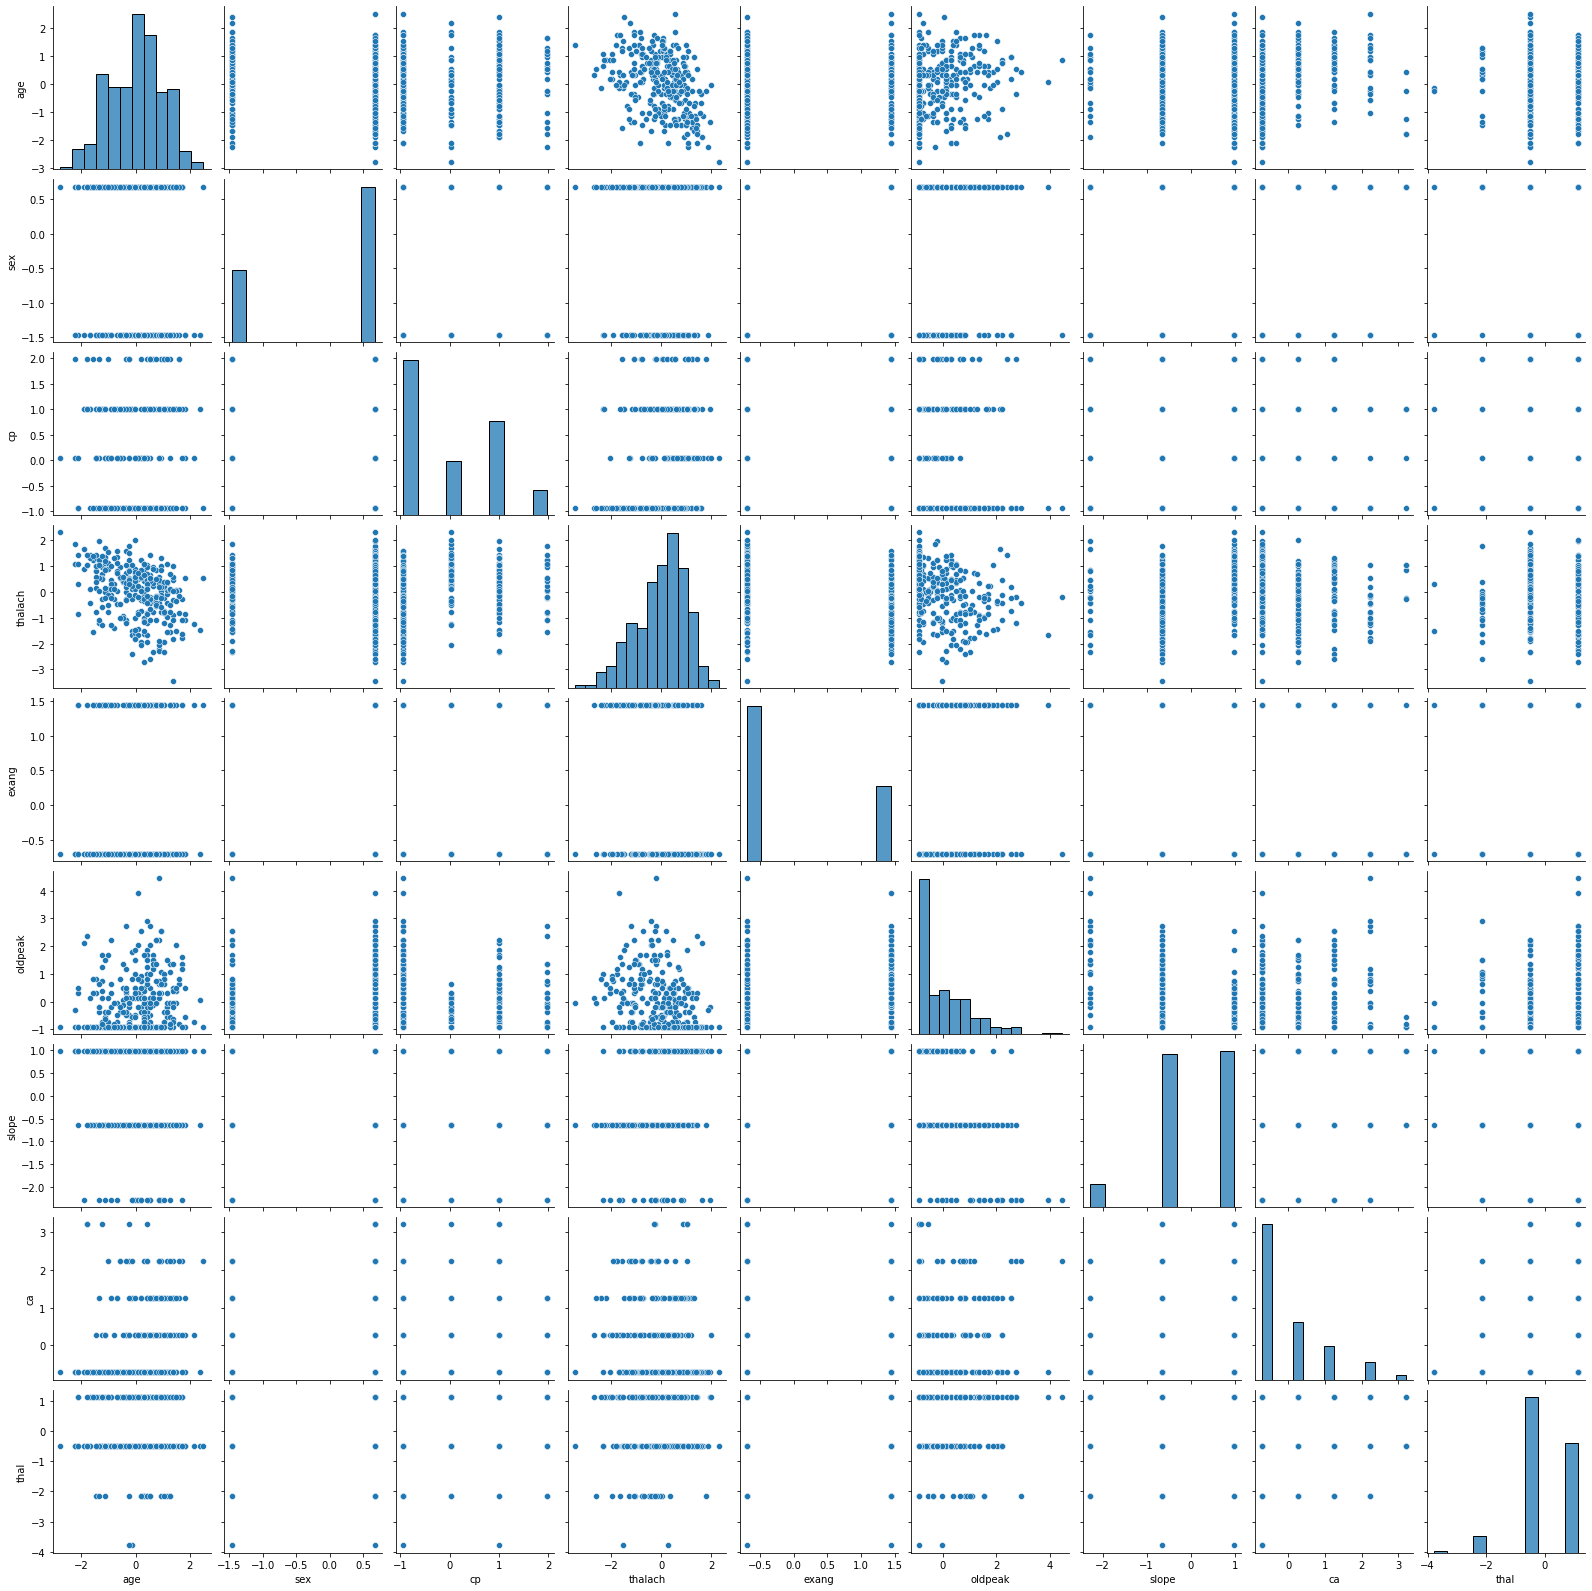

In [13]:
sns.pairplot(data = x)

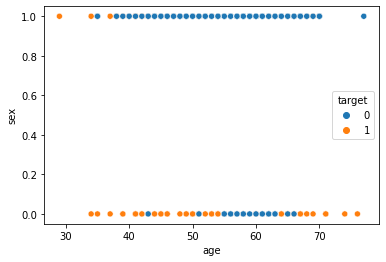

In [14]:
sns.scatterplot(x='age', y='sex', data=data, hue='target')

<h2>Now Explore Models<h2>

**Trying Logistic Regression**

In [15]:
#Split data to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

#Training Model
lModel = LogisticRegression(max_iter=500)
lModel.fit(X_train, y_train)

#Predicting
predictedVals = lModel.predict(X_train)


#Testing with test data
predictedTestVals = lModel.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))
print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))


Training Data's Confusion Matrix:
 [[ 75  21]
 [ 11 105]]
Testing Data's Confusion Matrix:
 [[31 11]
 [ 4 45]]

Training Data's Accuracy Score:  0.8490566037735849
Testing Data's Accuracy Score:  0.8351648351648352


Hmm, pretty good result we've got here but it's overfitted. But the thing is each time i use different sets of training and testing data, accuracy fluctuates. My theory is it's because of random splitting, sometimes training data encapsulates almost all characteristics of features and sometimes not. This in turn is because of less data available. Crossvalidation should do well in this case and we'll try that later on.

**Trying KNN Classifier**

In [16]:
#Train
kClassifier = KNeighborsClassifier(n_neighbors = 20)
kClassifier.fit(X_train, y_train)

predictedVals = kClassifier.predict(X_train)
predictedTestVals = kClassifier.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 72  24]
 [  8 108]]
Testing Data's Confusion Matrix:
 [[29 13]
 [ 3 46]]

Training Data's Accuracy Score:  0.8490566037735849
Testing Data's Accuracy Score:  0.8241758241758241


Hmm... Similar to Logistic Regression.
Now, let's try Decision Tree Classifier

**Trying Decision Tree Classifier**

In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
def parametersTuner(split = 5, leaf = 5, diff_threshold = 0.2):
  '''
    This function will select the best performing decision tree model over the given range of leaf and split params
    and within given threshold of acceptable range of accuracy deviation
    Params:
      split: (integer) 
      leaf: (integer)
      diff_threshold: (float) ==> Acceptable range of variation in train test data
    Returns: The best decision tree with optimal value of two parameters: min_sample_leaf and min_sample_split
  '''
  performanceRecord = {}    #ClassifierObject : (trainScore, testScore)
  for splitVar in range(2, split):
    for leafVar in range(1, leaf):

      #First instantiate a classifier object
      treeClassifier = DecisionTreeClassifier(min_samples_split=splitVar, min_samples_leaf = leafVar)

      #Then Train the classifier with the specified test parameters
      treeClassifier.fit(X_train, y_train)

      #Predict
      predictedVals = treeClassifier.predict(X_train)
      predictedTestVals = treeClassifier.predict(X_test)

      #Measure Accuracy
      trainScore = accuracy_score(y_train, predictedVals)
      testScore = accuracy_score(y_test, predictedTestVals)

      #Store the classifier and it's performance in dict object if the variance is inside acceptable range
      if abs(trainScore-testScore) <= diff_threshold and trainScore > 0.5 and testScore > 0.5:
        performanceRecord[treeClassifier] = (trainScore, testScore)

  #Sort the preformanceRecord in decending order with respect to testing accuracy
  performanceRecord = {k:v for k,v in sorted(performanceRecord.items(), key = lambda item: item[1])}

  #for k,v in performanceRecord.items():
   # print('\nClassifier: ', "\nAccuracy: ", v[1], "\nDifference: ", abs(v[0]-v[1]))                     
  
  #Compare performance of each classifier stored
  #Rules of optimal tree:
    #-> Least distance between test and train data prediction
    #-> Highest Accuracy
  optimalModel = {DecisionTreeClassifier() : (math.inf, 0)}     #ClassifierObject : (trainScore, testScore)
  for key, val in performanceRecord.items():
      if abs(val[0]-val[1]) < abs(optimalModel[next(iter(optimalModel))][0]-optimalModel[next(iter(optimalModel))][1]):
        optimalModel = {key: val}
  return optimalModel

optimalModel = parametersTuner(split = 9, leaf = 2, diff_threshold = 0.15)
trainScore = next(iter(optimalModel.values()))[0]
testScore = next(iter(optimalModel.values()))[1]

optimalModel = next(iter(optimalModel.keys()))

print('\nTraining Data\'s Accuracy Score: ', trainScore)
print('Testing Data\'s Accuracy Score: ', testScore)
print("Selected Model: ", optimalModel)


Training Data's Accuracy Score:  0.910377358490566
Testing Data's Accuracy Score:  0.8021978021978022
Selected Model:  DecisionTreeClassifier(min_samples_split=8)


Highly Overfitted. But at least it is what it is and it is what was expected of this model. Now lets try Random Forest to improve the accuracy.

**Trying Random Forest**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
randClassifier = RandomForestClassifier(n_estimators=15, criterion='entropy', max_depth=5)

randClassifier.fit(X_train, y_train)

predictedVals = randClassifier.predict(X_train)
predictedTestVals = randClassifier.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 84   8]
 [  2 118]]
Testing Data's Confusion Matrix:
 [[40  6]
 [ 5 40]]

Training Data's Accuracy Score:  0.9528301886792453
Testing Data's Accuracy Score:  0.8791208791208791


I don't know why but the accuracy is fluctuating everytime I train model.
Oh, I know why, it's the same with previous models because of the random train-test split of the data. 
Lets graph the fluctuating prediction accuracy.

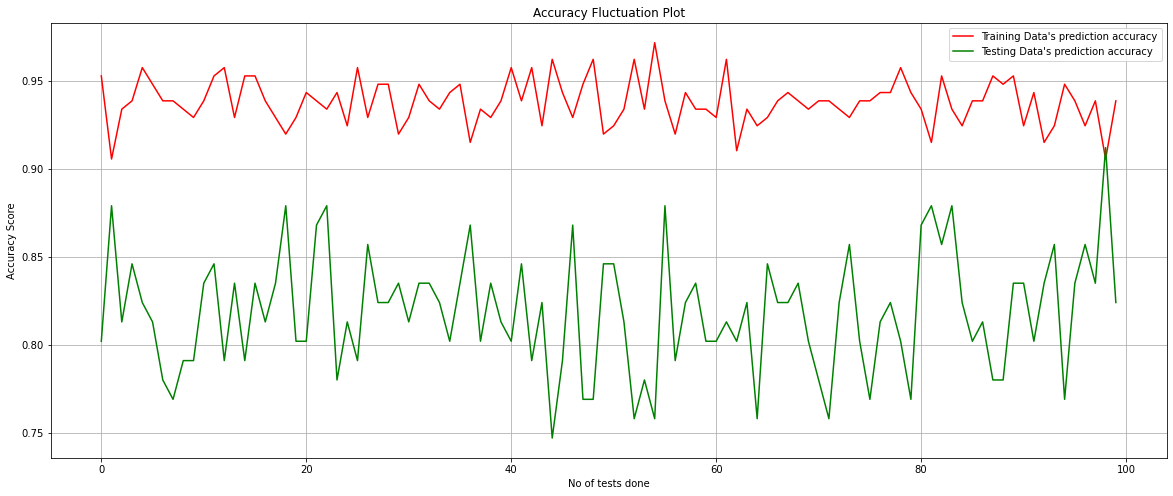

In [41]:
no_of_test = 100
train_accuracy = []
test_accuracy = []
for i in range(no_of_test):
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
  
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    randClassifier = RandomForestClassifier(n_estimators=15, criterion='gini', max_depth=5)
    
    randClassifier.fit(X_train, y_train)

    train_accuracy.append(accuracy_score(y_train, randClassifier.predict(X_train)))
    test_accuracy.append(accuracy_score(y_test, randClassifier.predict(X_test)))
    
_, axs = plt.subplots(figsize=(20,8))
plt.title("Accuracy Fluctuation Plot")
#plt.xkcd()        #Comic style I find cool
plt.plot(train_accuracy, color='red', label='Training Data\'s prediction accuracy')
plt.plot(test_accuracy, color='green', label='Testing Data\'s prediction accuracy')
plt.xlabel("No of tests done")
plt.ylabel("Accuracy Score")
plt.grid()
plt.legend()

Looking at the graph it seems like the fluctuating accuracies are sometimes soo good that it has good enough optimized hyperparameters but sometimes the model is overfitted.

For example look that the section in that graph where the two lines have intersected. At that particular split of data, the characteristics of training data has encapsulated almost all characteristics that testing data can have. That's why there is no variance.

But the important thing is this fluctuation has been happening all over this project and it's the very reason I splitted the training and testing data to select the best split which in turn gave better result with low variance and bias.

In [42]:
print("Min training accuracy: ", min(train_accuracy))
print("Max training Accuracy: ", max(train_accuracy))
print("Min Testing Accuracy: ", min(test_accuracy))
print("Max Testing accuracy: ", max(test_accuracy))

max_training_deviation = 0
min_training_deviation = math.inf
for i in range(len(train_accuracy)):
  if max_training_deviation < abs(train_accuracy[i]-test_accuracy[i]):
    max_training_deviation = abs(train_accuracy[i]-test_accuracy[i])
  if min_training_deviation > train_accuracy[i]-test_accuracy[i]:
    min_training_deviation = train_accuracy[i]-test_accuracy[i]
  

print("\nMax Accuracy Deviation: ", max_training_deviation)
print("Min Accuracy Deviation: ", min_training_deviation)       #Negative sign indicates the testing data performed better with the model than training

Min training accuracy:  0.9056603773584906
Max training Accuracy:  0.9716981132075472
Min Testing Accuracy:  0.7472527472527473
Max Testing accuracy:  0.9120879120879121

Max Accuracy Deviation:  0.21501140369064897
Min Accuracy Deviation:  -0.00642753472942148


**Let's try Bagging with different models**

In [47]:
classifierList = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), RandomForestClassifier()]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

def bestClassifier(givenModelList = [LogisticRegression()], deviationThreshold = 0.2):
    '''
        This function will select the best performing model among the given models with bagging algorithm.
        Unfortunately it cannot select those by tuning their parameter weights, so, yeah, sorry.
        Params: 
            givenModelList: List
    '''
    performanceRecord = {}   #Formet: {Model: (train accuracy, test accuracy, deviation)}
    
    #Test every model and record their performance
    est=10
    for model in givenModelList:
        #Make a model
        bagger = BaggingClassifier(base_estimator = model, n_estimators = est)

        #Training
        bagger.fit(X_train, y_train)

        #Predicting
        predictedVals = bagger.predict(X_train)
        predictedTestVals = bagger.predict(X_test)

        #Measuring test-train accuracy
        train_accuracy = accuracy_score(y_train, predictedVals)
        test_accuracy = accuracy_score(y_test, predictedTestVals)
        
        #Record the performance
        performanceRecord[bagger] = (train_accuracy, test_accuracy, train_accuracy-test_accuracy)
        
    #Sort the models with highets testing accuracy at top
    sortedRecord = {k:v for k,v in sorted(performanceRecord.items(), key = lambda items: items[1][1], reverse=True)}
    
    #Select the model with best preformance
    #Performance Better means with high test accuracy and less deviation
    bestTillNow = {None: (0, 0, math.inf)}
    
    for k,v in sortedRecord.items():
        if v[2] <= deviationThreshold:
            bestTillNow = {k: v}
            break
        else:
            try:
                if next(iter(bestTillNow))[2] > v[2]:
                    bestTillNow = {k: v}
            except TypeError:
                print("No model gave any result with that deviation threshold. It's too small.")
                return None, None
    return bestTillNow, sortedRecord
    
bestClassifier, record = bestClassifier(givenModelList = classifierList, deviationThreshold = 0.03)
bestClassifier

{BaggingClassifier(base_estimator=KNeighborsClassifier()): (0.8726415094339622,
  0.8791208791208791,
  -0.006479369686916869)}

This approach turned out to be the best performing model till now in testing dataset. The negetive sign is because it perfored better in testing set than training.

In [48]:
print('Best Bagging Classifier: ', next(iter(bestClassifier.keys())))
accuracy = bestClassifier[next(iter(bestClassifier.keys()))]

print('Training Accuracy: ', accuracy[0])
print('Testing Accuracy: ', accuracy[1])
print('Deviation: ', accuracy[2])

Best Bagging Classifier:  BaggingClassifier(base_estimator=KNeighborsClassifier())
Training Accuracy:  0.8726415094339622
Testing Accuracy:  0.8791208791208791
Deviation:  -0.006479369686916869


Negative deviation means that the training accuracy is lower than testing.

**Now time for some Boostin'**

In [272]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

gBooster = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 80, max_depth = 2)

gBooster.fit(X_train, y_train)

predictedVals = gBooster.predict(X_train)
predictedTestVals = gBooster.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 93   8]
 [  9 102]]
Testing Data's Confusion Matrix:
 [[34  3]
 [ 5 49]]

Training Data's Accuracy Score:  0.9198113207547169
Testing Data's Accuracy Score:  0.9120879120879121


Look at this beauty here. Makes me want to see again and again. I mean, 91% accuracy is no joke for me. Never achieved this good accuracy.

Boosting did what it was built to do perfectly. It combined weak learners and produced a strong learning model, a classic definition.

In [279]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

aBooster = AdaBoostClassifier(base_estimator = LogisticRegression(), learning_rate = 0.1, n_estimators = 100, algorithm = 'SAMME.R')

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

aBooster.fit(X_train, y_train)

predictedVals = aBooster.predict(X_train)
predictedTestVals = aBooster.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 69  25]
 [ 10 108]]
Testing Data's Confusion Matrix:
 [[39  5]
 [ 5 42]]

Training Data's Accuracy Score:  0.8349056603773585
Testing Data's Accuracy Score:  0.8901098901098901


This is also good but I hit Ctrl+Enter for like dozens of time to find this balanced classification. It's not practical in real world I suppose.

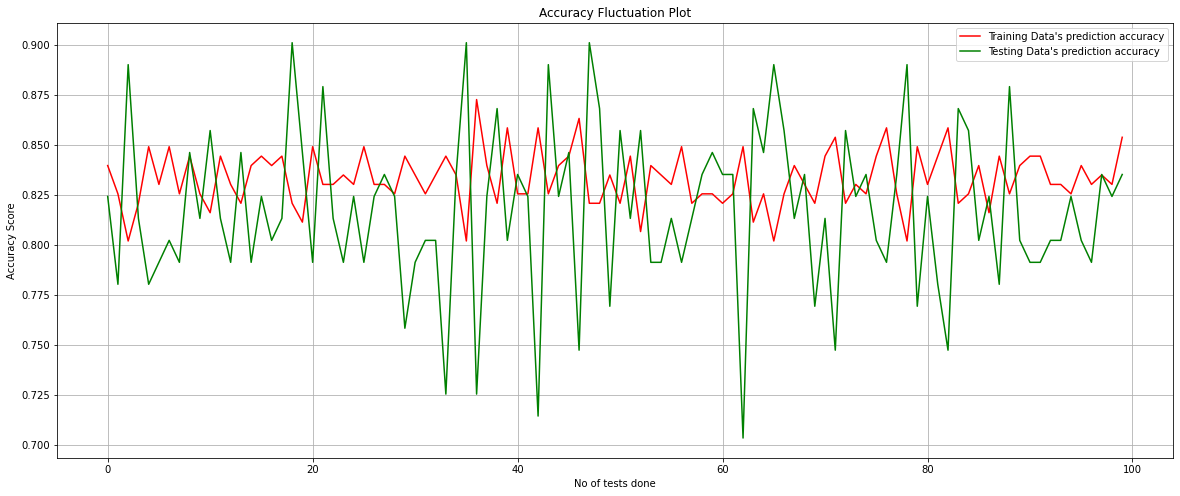

In [280]:
no_of_tests = 100
trAccuracyHistory = []
teAccuracyHistory = []

for i in range(no_of_tests):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    aBooster = AdaBoostClassifier(base_estimator = LogisticRegression(), learning_rate = 0.01, n_estimators = 100, algorithm = 'SAMME.R')

    aBooster.fit(X_train, y_train)

    predictedVals = aBooster.predict(X_train)
    predictedTestVals = aBooster.predict(X_test)
    
    trAccuracyHistory.append(accuracy_score(y_train, predictedVals))
    teAccuracyHistory.append(accuracy_score(y_test, predictedTestVals))

plt.subplots(figsize=(20,8))    
plt.title("Accuracy Fluctuation Plot")
plt.plot(trAccuracyHistory, color='red', label='Training Data\'s prediction accuracy')
plt.plot(teAccuracyHistory, color='green', label='Testing Data\'s prediction accuracy')
plt.xlabel("No of tests done")
plt.ylabel("Accuracy Score")
plt.grid()
plt.legend()

Look at those fluctuations. Man, this is crazy. I seriously need more data for some consistancy here.

**Lets try Support Vector Machine**

Here I've tried to compare the performance of all available learning algorithms for this Support Vector Machine at once with hundred repetitions so that I can compare performance of each one of them in a sight.


Training Data's Accuracy Score:  0.6509433962264151
Testing Data's Accuracy Score:  0.7142857142857143


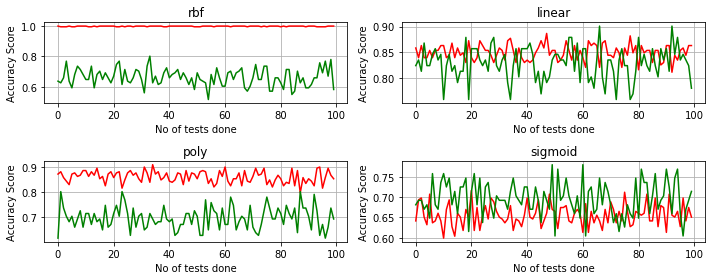

In [281]:
plotting_vals = []
training_weight = 0
givenKernel = ['rbf', 'linear', 'poly', 'sigmoid']

for kernel in givenKernel:
    no_of_tests = 100
    test_accuracy_record = []
    train_accuracy_record = []
    
    for i in range(no_of_tests):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

        svmClassifier = svm.SVC(gamma = 2, degree = 2, kernel = kernel, C = 5.0)

        svmClassifier.fit(X_train, y_train)

        predictedVals = svmClassifier.predict(X_train)
        predictedTestVals = svmClassifier.predict(X_test)

        train_accuracy_record.append(accuracy_score(y_train, predictedVals))
        test_accuracy_record.append(accuracy_score(y_test, predictedTestVals))
    plotting_vals.append((train_accuracy_record, test_accuracy_record))

    

#Plotting the accuracy fluctuation graph
nrows = 2
ncols = 2
_, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10,4))    
plt.title("Accuracy Fluctuation Plot")

tempIndex = 0
for i in range(nrows):
    for j in range(ncols):
        axs[i][j].set_title(givenKernel[tempIndex])
        axs[i][j].plot(plotting_vals[tempIndex][0], color='red', label='Training Data\'s prediction accuracy')
        axs[i][j].plot(plotting_vals[tempIndex][1], color='green', label='Testing Data\'s prediction accuracy')
        axs[i][j].set_xlabel("No of tests done")
        axs[i][j].set_ylabel("Accuracy Score")
        axs[i][j].grid()
        tempIndex += 1
plt.tight_layout()

#print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
#print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Here we can see, among the four algorithms, *linear* did a great job. It has the lowest deviation in train-test accuracy and the testing accuracy is almost higher than 80% in most cases. If only I had enough data, this kind of fluctuation could have been avoided.

**Let's try some Cross Validation**

In [283]:
def crossClassifierTests(X_train, y_train):
    meanAccuracy = []

    for i in givenClassifiers:
        cValidate = cross_validate(estimator = i,
                                  X = X_train,
                                  y = y_train,
                                  cv = 10,
                                  )
        meanAccuracy.append(cValidate['test_score'].mean())
    return meanAccuracy

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

givenClassifiers = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), svm.SVC(kernel='linear',
                                                                                                     gamma = 2,
                                                                                                     degree=2,
                                                                                                     C = 5.0)]

mean_accuracy = crossClassifierTests(X_train, y_train)

for i in range(len(mean_accuracy)):
    print(f"Mean Accuracy of {givenClassifiers[i]} :  {mean_accuracy[i]*100}%")


Mean Accuracy of LogisticRegression() :  84.3%
Mean Accuracy of DecisionTreeClassifier() :  80.19999999999999%
Mean Accuracy of RandomForestClassifier() :  84.35000000000001%
Mean Accuracy of SVC(C=5.0, degree=2, gamma=2, kernel='linear') :  83.9%


Lets plot the graph of mean accuracy fluctuations

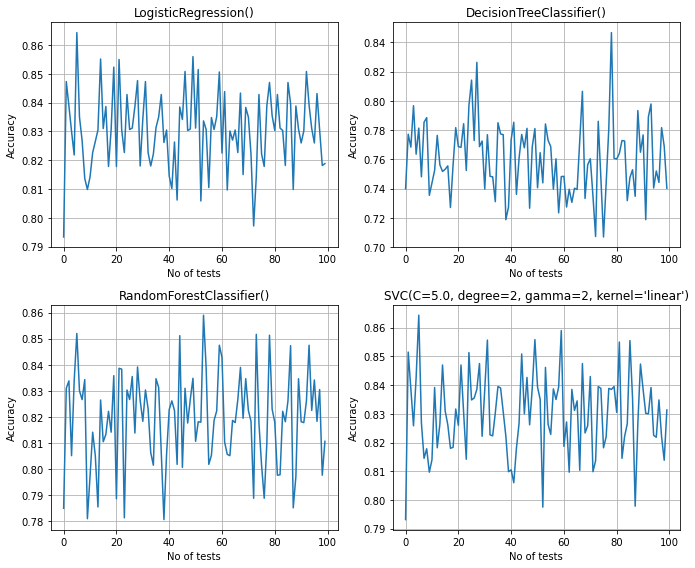

In [285]:
no_of_tests = 100

accuracyRecord = []   #2d matrix

for i in range(no_of_tests):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    accuracyRecord.append(crossClassifierTests(X_train, y_train))

_, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10,8))

index = 0

for i in range(nrows):
    for j in range(ncols):
        axs[i][j].set_title(givenClassifiers[index])
        axs[i][j].set_xlabel("No of tests")
        axs[i][j].set_ylabel('Accuracy')
        axs[i][j].grid()
        axs[i][j].plot([k[index] for k in accuracyRecord])
        index += 1
plt.tight_layout()

As expected, LogisticRegression did the best among the four because the fluctuation extremas are between 0.79 and 0.86 i.e. deviation of 0.07 or 7%.
So, lets make it's accuracy score of 0.825 or 82.5%. Average of the extremes.

<h2>The Final Selected Model </h2><h3>If I had to choose one</h3><br>
</h3>gBooster</h3>

In [303]:
#lets make a function that will draw a random feature from the dataset and 
#predict and compare the predicted and true values
no_of_tests = 10
def predictValue(no_of_tests, print_results = False):
    '''
    This function predicts randomly selected value from the dataset and predicts
    Compares and prints the actual and predictes values if [print_results] is passed as True and
    returns accuracy of the [no_of_tests] tests
    '''
    accurate_or_not = []
    for _ in range(no_of_tests):
        random_index = np.random.randint(0, len(data['target']), 1)
        final_x=x.iloc[random_index, :]
        final_target = yd[random_index]
        finalPredictedVal = gBooster.predict(final_x)
        
        if print_results:
            print(f'\nTest #{_}')
            print('True: ', final_target)
            print("Predicted: ", finalPredictedVal)
        accurate_or_not.append(final_target == finalPredictedVal)
    return len([i for i in accurate_or_not if i])/len(accurate_or_not) * 100
accuracy = predictValue(no_of_tests)
print("Accuracy: "+ str(accuracy)+"%")

Accuracy: 100.0%


<h3>Something like ensemble I thought could do well</h3><br>
What if we used all these algoithms and used all of their predictions to predict the ultimate state? Sounds like it could do something great. Let's try it.<br>Here're all the models I've trained:
<ul>
    <li>lModel</li>
    <li>kClassifier</li>
    <li>optimalModel</li>
    <li>randClassifier</li>
    <li>next(iter(bestClassifier)) ===>  Its a bagging classifier inside dictionary so I had to access using iterable</li>
    <li>gBooster</li>
    <li>aBooster</li>
    <li>svmClassifier</li>
</ul>
Let's use these babies.

In [340]:
allModels = [
    lModel,
    kClassifier,
    optimalModel,
    randClassifier,
    next(iter(bestClassifier)),
    gBooster,
    aBooster,
    svmClassifier
]
random_index = np.random.randint(0, len(data['target']), 1)

final_x=x.iloc[random_index, :]
final_target = data['target'].values[random_index]

def predictUsingAll(X_value):
    predictedResults = []
    for model in allModels:
        predictedResults.append(model.predict(X_value)[0])
    countedPredictions = collections.Counter(predictedResults)
    return 1 if countedPredictions[1] > countedPredictions[0] else 0
    
print("True Value: "+str(final_target[0])+"\nPredicted Value: "+str(predictUsingAll(final_x)))

True Value: 1
Predicted Value: 1


Let's check how much good it is

In [359]:
correct_or_not = []

no_of_tests = 1000

for i in range(no_of_tests):
    final_x=x.iloc[random_index, :]
    final_target = data['target'].values[random_index]
    correct_or_not.append(True if final_target == predictUsingAll(final_x) else False)

counted = collections.Counter(correct_or_not)
print('Accuracy: '+str(counted[1]/(counted[1]+counted[0])*100)+"%\nNo of tests: "+str(no_of_tests))

Accuracy: 100.0%
No of tests: 1000


**OMG IT WORKED**
<br>
100 percent accuracy is what I work for...
<br>
So the final model I choose is the democratic model where every model's performance counts. Every model is equally treated. ;V
<h3>Final Model: predictUsingAll()</h3>
<br><br>
Thanks for sticking upto now.